In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 5000)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

#modeling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn_pandas import DataFrameMapper
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

## Creating a Baseline LightGBM Model

Scores for Baseline Model
R^2                   0.19
RMSE                368.38
MAE                 239.04
TrainingTime(sec)     4.80
dtype: float64


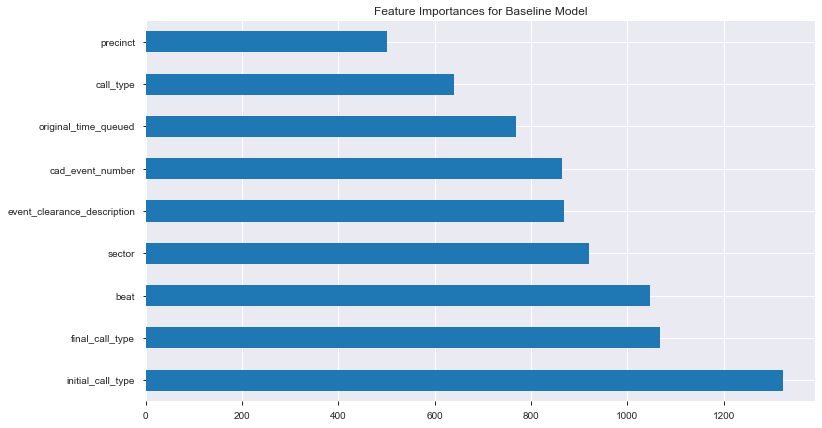

In [94]:
#read in data
df = pd.read_csv('Call_Data.csv', nrows = 1000000)

def clean_df(df):
    
    #subset the df to include only calls of priority 1
    df= df[df['Priority'] == 1]
    
    #drop the priority column
    df = df.drop('Priority', axis = 1)
    
    #drop nulls
    df = df.dropna()
    
    #lower-case entire dataset
    df = df.applymap(lambda s: s.lower() if type(s) == str else s)
    
    #lower-case column names
    df.columns = [c.lower() for c in df.columns]
    
    #replace space with underbar in columns
    df.columns = [c.replace(' ', '_') for c in df.columns]
    
    #convert que time to datetime
    df['original_time_queued'] = pd.to_datetime(df['original_time_queued'])
    
    #create datetime object from arrived time
    df['arrived_time'] = [datetime.strptime(x, "%b %d %Y %I:%M:%S:%f%p") for x in df['arrived_time']]
    
    #engineering target feature response time
    df['total_response_time'] = df['arrived_time'] - df['original_time_queued']
    
    #create response time in seconds
    df['total_response_time'] = df['total_response_time'].dt.total_seconds()
    
    #just drop the response times that are negative
    to_drop = df[df['total_response_time'] < 0]

    df.drop(to_drop.index, inplace = True)
    
    #reset the index since we dropped negative response times
    df.reset_index(drop = True, inplace = True)
    
    #outlier function
    def z_score_indices_of_outliers(X, threshold=3):
        X_mean = np.mean(X)
        X_stdev = np.std(X)
        z_scores = [(y - X_mean) / X_stdev for y in X]
        z_df = pd.DataFrame(z_scores)
        pos_outliers = z_df[z_df[0] > 3]
        neg_outliers = z_df[z_df[0] < -3]
        return pos_outliers; neg_outliers
    
    #find and remove outliers at 3stds
    response_time_outliers = z_score_indices_of_outliers(df['total_response_time'])
    
    #drop outliers and reset the index again
    df = df.drop(response_time_outliers.index).reset_index(drop = True)
    
    return df
    
#creating df
df = clean_df(df)

#create function for scoring model
def train_model_get_score(df, model):
    
    #returning datetime objects to strings for model training
    df['arrived_time'] = [datetime.strftime(x, "%b %d %Y %I:%M:%S:%f%p") for x in df['arrived_time']]
    df['original_time_queued'] = [datetime.strftime(x, "%b %d %Y %I:%M:%S:%f%p") for x in df['original_time_queued']]
    
    #select features and target
    features = df.drop(['total_response_time', 'arrived_time'], axis = 1)
    labels = df['total_response_time']
    
    #Label Encoding features
    for x in features.columns[features.dtypes == 'object']:
        features[x] = features[x].factorize()[0]
        
    
    #split training data into train and test set for validation
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = .2, random_state = 49)
    
    
    def get_score(model):

        from sklearn.metrics import mean_squared_error, mean_absolute_error
        import time

        startTime = time.time()  # Getting training time
        
        # Fits with training set
        model.fit(X_train, y_train)
        totalTime = time.time() - startTime
        predictions = model.predict(X_test)
        
        r2 = model.score(X_test, y_test)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
            
        score_results = pd.Series([r2, rmse, mae, totalTime], index=['R^2', 'RMSE', 'MAE', 'TrainingTime(sec)'])
        
        #plotting feature importances
        feature_importances = pd.Series(model.feature_importances_, index=features.columns)
        feature_importances.nlargest(20).plot(kind='barh', title = 'Feature Importances for Baseline Model', figsize = (12, 7))
        
        return score_results
    
    #get score for model
    score = get_score(model)

    print('Scores for Baseline Model')

    print(f'{score}')

#instatiate model and get results
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=2000, max_bin = 55, bagging_fraction = 0.8,
                                  bagging_freq = 5, feature_fraction = 0.2319, feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf =6, 
                                  min_sum_hessian_in_leaf = 11)

#score basline model
train_model_get_score(df, model_lgb)

## Results
- __It appears as though our baseline model can predict response times within 6 minutes for priority 1 calls__

In [95]:
368/60

6.133333333333334

# Exploratory Data Analysis
- __Now that we have an idea of what our baseline model is, we can start looking into the data and creating a model that may predict more accurately__